In [70]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Create a class which can take in value and if possible also do backpropagation throught the network
Why are gradients added and not just assigned? 
It turns out that if the values are used in more than 2 operations, the gradient of the second variable will overwrite the gradient of tprevious operation
In order to avoid this we need to accumulate the gradient -> Multivariate calculus

In [71]:
class Value:
    """Stores a single scalar value and its gradient"""

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.grad = 0.0
        self._backward = lambda: None
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), "+")

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), "*")

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward
        return out

    def __pow__(self, other):
        assert isinstance(
            other, (int, float)
        ), "only supporting int/float powers for now"
        assert isinstance(
            other, (int, float)
        ), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f"**{other}")

        def _backward():
            self.grad += (other * self.data ** (other - 1)) * out.grad

        out._backward = _backward

        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2 * x) - 1) / (math.exp(2 * x) + 1)
        out = Value(t, (self,), "tanh")

        def _backward():
            self.grad += (1 - t**2) * out.grad

        out._backward = _backward

        return out

    def relu(self):
        out = Value(0 if self.data < 0 else self.data, (self,), "ReLU")

        def _backward():
            self.grad += (out.data > 0) * out.grad

        out._backward = _backward
        return out

    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

    def __neg__(self):  # -self
        return self * -1

    def __radd__(self, other):  # other + self
        return self + other

    def __sub__(self, other):  # self - other
        return self + (-other)

    def __rsub__(self, other):  # other - self
        return other + (-self)

    """
    This is important because if we have Value(a) and we do 2*Value(a) it won't work
    This is a fallback operation and allows us to peform operations without having to worry about the data type
    """

    def __rmul__(self, other):  # other * self
        return self * other

    def __truediv__(self, other):  # self / other
        return self * other**-1

    def __rtruediv__(self, other):  # other / self
        return other * self**-1

In [72]:
a = Value(3, label = 'a')

In [31]:
!pip install graphviz


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [73]:
from graphviz import Digraph


def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)

    build(root)
    return nodes, edges


def draw_dot(root):
    dot = Digraph(format="svg", graph_attr={"rankdir": "LR"})  # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(
            name=uid,
            label="{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad),
            shape="record",
        )
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name=uid + n._op, label=n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [57]:
# inputs x1,x2
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")
# weights w1,w2
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")
# bias of the neuron
b = Value(6.8813735870195432, label="b")
# x1*w1 + x2*w2 + b
x1w1 = x1 * w1
x1w1.label = "x1*w1"
x2w2 = x2 * w2
x2w2.label = "x2*w2"
x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = "x1*w1 + x2*w2"
n = x1w1x2w2 + b
n.label = "n"
o = n.tanh()
o.label = "o"
o.backward()

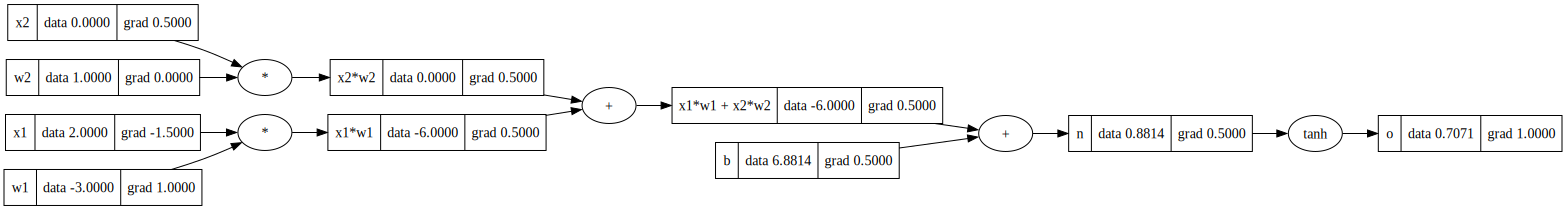

In [58]:
draw_dot(o)

Implement neuron and Layer for building Multilayer perceptron class

In [60]:
import random

In [107]:
import random

class Module:
    def zero_grad(self):
        for p in self.parameters():
            p.grad = 0

    def parameters(self):
        return []


class Neuron(Module):
    def __init__(self, nin, nonlin=True):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(0)
        self.nonlin = nonlin

    def __call__(self, x):
        act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
        return act.relu() if self.nonlin else act

    def parameters(self):
        return self.w + [self.b]

    def __repr__(self):
        return f"{'ReLU' if self.nonlin else 'Linear'}Neuron({len(self.w)})"


class Layer(Module):
    def __init__(self, nin, nout, **kwargs):
        self.neurons = [Neuron(nin, **kwargs) for _ in range(nout)]

    def __call__(self, x):
        out = [n(x) for n in self.neurons]
        return out[0] if len(out) == 1 else out

    def parameters(self):
        return [p for n in self.neurons for p in n.parameters()]

    def __repr__(self):
        return f"Layer of [{', '.join(str(n) for n in self.neurons)}]"


class MLP(Module):
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [
            Layer(sz[i], sz[i + 1], nonlin=i != len(nouts) - 1)
            for i in range(len(nouts))
        ]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

    def __repr__(self):
        return f"MLP of [{', '.join(str(layer) for layer in self.layers)}]"

In [108]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-1.7890751495375359, grad=0.0)

In [109]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]

In [110]:
for k in range(20):
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt) ** 2 for ygt, yout in zip(ys, ypred))

    # backward pass
    # Why do you flush out the gradients? 
    '''You should know this by now -> The gradients get accumulated when trying to backpropagate 
    What this means is when loss.backward() is called the gradients from the previous step gets added making the gradients more negative or positive and hence changing the data
    which now also accumulates all the gradient
    '''
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()

    # update
    # the 0.1 is the learning rate
    for p in n.parameters():
        p.data += -0.1 * p.grad

    print(k, loss.data)

0 11.414905434771226
1 2.6424163681769604
2 24.58255224470681
3 20.091827309211062
4 4.643673092368442
5 4.025746923694737
6 4.00102987694779
7 4.000041195077912
8 4.000001647803116
9 4.0000000659121255
10 4.000000002636485
11 4.000000000105459
12 4.000000000004218
13 4.000000000000169
14 4.000000000000007
15 4.0
16 3.999999999999999
17 4.0
18 4.0
19 4.0


Trying something with sklearn datasets to see if the neural networks learn something

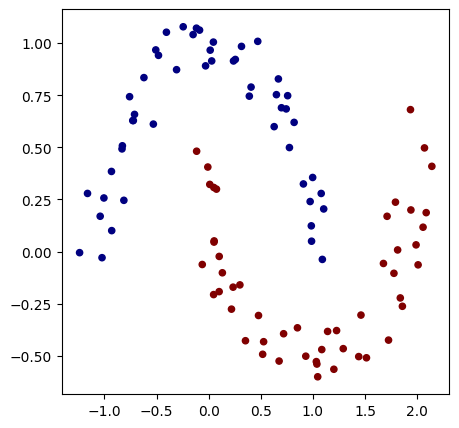

In [111]:
from sklearn.datasets import make_moons, make_blobs

X, y = make_moons(n_samples=100, noise=0.1)

y = y * 2 - 1  # make y be -1 or 1
# visualize in 2D
plt.figure(figsize=(5, 5))
plt.scatter(X[:, 0], X[:, 1], c=y, s=20, cmap="jet")

In [112]:
model = MLP(2, [16, 16, 1])  # A two layer neural network
print(model)
print("number of parameters", len(model.parameters()))

MLP of [Layer of [ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2)], Layer of [ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16)], Layer of [LinearNeuron(16)]]
number of parameters 337


In [113]:
def loss(batch_size=None):
    if batch_size is None:
        Xb, yb = X, y
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri]
    inputs = [list(map(Value, xrow)) for xrow in Xb]

    # forward the model to get scores
    scores = list(map(model, inputs))

    # svm "max-margin" loss
    losses = [(1 + -yi * scorei).relu() for yi, scorei in zip(yb, scores)]
    data_loss = sum(losses) * (1.0 / len(losses))
    # L2 regularization
    alpha = 1e-4
    reg_loss = alpha * sum((p * p for p in model.parameters()))
    total_loss = data_loss + reg_loss

    # also get accuracy
    accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)]
    return total_loss, sum(accuracy) / len(accuracy)

In [114]:
total_loss, acc = loss()
print(total_loss, acc)

Value(data=2.2794403899752806, grad=0.0) 0.5


In [115]:
for k in range(100):
    # forward
    total_loss, acc = loss()

    # backward
    model.zero_grad()
    total_loss.backward()

    # update (sgd)
    learning_rate = 1.0 - 0.9 * k / 100
    for p in model.parameters():
        p.data -= learning_rate * p.grad

    if k % 1 == 0:
        print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%")

step 0 loss 2.2794403899752806, accuracy 50.0%
step 1 loss 0.73147514204118, accuracy 76.0%
step 2 loss 2.831952175118576, accuracy 50.0%
step 3 loss 0.6849415010072158, accuracy 77.0%
step 4 loss 0.4429493128091286, accuracy 81.0%
step 5 loss 0.39686022794659026, accuracy 80.0%
step 6 loss 0.3530067658292392, accuracy 82.0%
step 7 loss 0.31335585260493176, accuracy 87.0%
step 8 loss 0.27134627719374105, accuracy 89.0%
step 9 loss 0.23216606337874932, accuracy 90.0%
step 10 loss 0.27269121289930665, accuracy 90.0%
step 11 loss 0.197357299149164, accuracy 91.0%
step 12 loss 0.17503717385805193, accuracy 91.0%
step 13 loss 0.18299939260239043, accuracy 95.0%
step 14 loss 0.366044836839753, accuracy 90.0%
step 15 loss 0.19934488395286518, accuracy 90.0%
step 16 loss 0.1490365725867241, accuracy 94.0%
step 17 loss 0.15854626184321677, accuracy 95.0%
step 18 loss 0.2541877717137804, accuracy 91.0%
step 19 loss 0.16364294700793755, accuracy 93.0%
step 20 loss 0.1105444450643976, accuracy 96.

(15, 22)


(-1.601434369800238, 1.898565630199762)

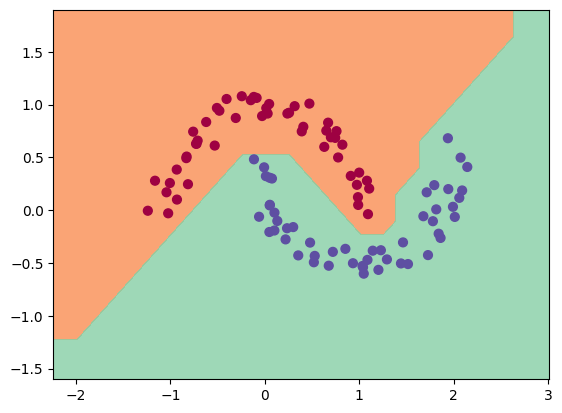

In [117]:
h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = list(map(model, inputs))
Z = np.array([s.data > 0 for s in scores])
print(xx.shape)
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())